In [1]:
##before continuing the following packages need to be runned
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [2]:
portfolio_data <- read_csv("final_data.csv")|>
mutate(max_portfolio_return_name = as_factor(max_portfolio_return_name))|>
select(-year, -max_portfolio_return_value)
portfolio_data

Rows: 25 Columns: 6
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): max_portfolio_return_name
dbl (5): year, annual_inflation, real_gdp_growth_rate_percentage, annual_une...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


annual_inflation,real_gdp_growth_rate_percentage,annual_unemployment_rate,max_portfolio_return_name
<dbl>,<dbl>,<dbl>,<fct>
2.337690,4.4,4.950000,60/40_portfolio_return_percentage
1.552279,4.5,4.508333,growth_portfolio_return_percentage
2.188027,4.8,4.216667,growth_portfolio_return_percentage
⋮,⋮,⋮,⋮
1.812210,2.3,3.666667,growth_portfolio_return_percentage
1.233584,-3.4,8.091666,growth_portfolio_return_percentage
4.697859,5.7,5.366667,growth_portfolio_return_percentage


In [3]:
#exloring our data:

num_obs <- nrow(portfolio_data)

portfolio_data |>
group_by(max_portfolio_return_name) |>
summarize(count = n(), percentage = n() / num_obs * 100)

#Word of caution: data seems to have too much "growth_portfolio" labels. Thus, rebalancing could be attempted: 

max_portfolio_return_name,count,percentage
<fct>,<int>,<dbl>
60/40_portfolio_return_percentage,4,16
growth_portfolio_return_percentage,15,60
income_portfolio_return_percentage,5,20
40/60_portfolio_return_percentage,1,4


In [6]:
#performing rebalancing:
library(themis)

ups_recipe <- recipe(max_portfolio_return_name ~ ., data = portfolio_data) |>
step_upsample(max_portfolio_return_name, over_ratio = 1, skip = FALSE) |>
prep()
ups_recipe

upsampled_portfolio <- bake(ups_recipe, portfolio_data)

upsampled_portfolio |>
group_by(max_portfolio_return_name) |>
summarize(n = n())

ERROR: Error in library(themis): there is no package called ‘themis’


In [7]:
#comparing upsampled vs normal data:

print(upsampled_portfolio)
print (portfolio_data)

ERROR: Error in print(upsampled_portfolio): object 'upsampled_portfolio' not found


As seen above, upsampling would harm our data as it would create fictitious data points just for the sake of balancing out the labels. This in turn, would harm our real-life prediction accuracy interpretation since the data point created don't make any real sense.Therefore, for the rest of the classification, we won't be using upsampled data.

In [8]:
set.seed(9999) #ensuring reproducibility
options(repr.plot.height = 5, repr.plot.width = 6)

#splitting with normal data:
portfolio_split <- initial_split(portfolio_data, prop = 0.75, strata = max_portfolio_return_name)
portfolio_train <- training(portfolio_split)
portfolio_test <- testing(portfolio_split) 


#exploring distribution of labels in each split:

portfolio_train |>
group_by(max_portfolio_return_name) |>
summarize(count = n(), percentage = n() / num_obs * 100)

portfolio_test |>
group_by(max_portfolio_return_name) |>
summarize(count = n(), percentage = n() / num_obs * 100)

max_portfolio_return_name,count,percentage
<fct>,<int>,<dbl>
60/40_portfolio_return_percentage,3,12
growth_portfolio_return_percentage,11,44
income_portfolio_return_percentage,3,12
40/60_portfolio_return_percentage,1,4


max_portfolio_return_name,count,percentage
<fct>,<int>,<dbl>
60/40_portfolio_return_percentage,1,4
growth_portfolio_return_percentage,4,16
income_portfolio_return_percentage,2,8


The distribution of both split and test indicate that most of the data labels are "growth_portfolio". Hence this is something to bare and be critical when interptreting our predictions below. The best way to avoid this is to ideally collect data of more years since, as mentioned above, upsampling would harm the real-life applicability of the model. 

In [9]:
#recipe with normal data:
knn_recipe <- recipe(max_portfolio_return_name ~ annual_inflation + real_gdp_growth_rate_percentage + annual_unemployment_rate, data = portfolio_train) |>
    step_center(all_predictors()) |>
    step_scale (all_predictors())

In [10]:
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |> 
set_engine("kknn") |>
set_mode("classification") 

! Fold1: preprocessor 1/1, model 1/1: 15 samples were requested but there were 13 rows in the data. 8 will be ...

! Fold1: preprocessor 1/1, model 1/1 (predictions): data length [65] is not a sub-multiple or multiple of the number of colu...

! Fold1: internal:
  No observations were detected in `truth` for level(s): '60/40_portfoli...
  Computation will proceed by ignoring those levels.

! Fold2: preprocessor 1/1, model 1/1: 15 samples were requested but there were 13 rows in the data. 8 will be ...

! Fold2: internal:
  No observations were detected in `truth` for level(s): '40/60_portfoli...
  Computation will proceed by ignoring those levels., No observations we...
  Computation will proceed by ignoring those levels.

! Fold3: preprocessor 1/1, model 1/1: 15 samples were requested but there were 14 rows in the data. 9 will be ...

! Fold3: internal:
  No observations were detected in `truth` for level(s): '40/60_portfoli...
  Computation will proceed by ignoring those levels., No 

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
4,accuracy,multiclass,0.7,5,0.1264911,Preprocessor1_Model04
5,accuracy,multiclass,0.7,5,0.1264911,Preprocessor1_Model05
6,accuracy,multiclass,0.7,5,0.1264911,Preprocessor1_Model06
⋮,⋮,⋮,⋮,⋮,⋮,⋮
3,accuracy,multiclass,0.66,5,0.1400000,Preprocessor1_Model03
13,accuracy,multiclass,0.66,5,0.1536229,Preprocessor1_Model13
14,accuracy,multiclass,0.58,5,0.1800000,Preprocessor1_Model14


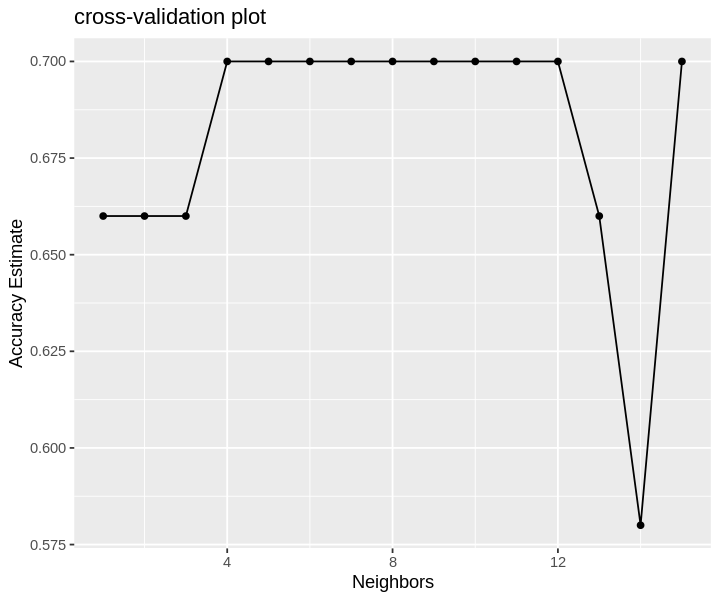

In [11]:
set.seed(9999) #ensuring reproducibility

knn_vfold <- vfold_cv(portfolio_train, v = 5, strata = max_portfolio_return_name)
gridvals <- tibble(neighbors = seq(from = 1, to = 15))

knn_results <- workflow() |>
  add_recipe(knn_recipe) |>
  add_model(knn_tune) |>
  tune_grid(resamples = knn_vfold, grid = gridvals) |>
  collect_metrics() 

accuracies <- knn_results |> 
       filter(.metric == "accuracy") |>
       arrange(desc(mean))
accuracies


cross_val_plot <- ggplot(accuracies, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       labs(x = "Neighbors", y = "Accuracy Estimate") +
       ggtitle("cross-validation plot")
cross_val_plot

In [12]:
# based on the plot,  we will pick K=8 because it the median neighbor between the equal-accuracy-range of K= 4-12. choosing k=8 ensures that going a bit to the righ or left leaves the accuracy estimate intact
# We certainly believe that in order to enhance our model, more data should be collected for each variable. 
# Unfortunatly, our data was restricted for data from 1997-2021.

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 8) |>
set_engine("kknn") |>
set_mode("classification")

knn_fit <- workflow() |>
add_recipe(knn_recipe) |>
add_model(knn_spec) |>
fit(data = portfolio_train)

In [13]:
#testing model predictions with testing set

set.seed(9999) #ensuring reproducibility

test_predictions <- predict(knn_fit,portfolio_test) |>
bind_cols(portfolio_test)

knn_metrics <- test_predictions |>
metrics(truth = max_portfolio_return_name, estimate = .pred_class)
knn_metrics
#accuracy seems to improve a bit (from 70% up to ~71%) when applying model to testing dataset

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.7142857
kap,multiclass,0.3913043


In [14]:
#This is the new observation to predict

new_economic_environment_1 <- tibble(annual_inflation = 2, real_gdp_growth_rate_percentage = 5, annual_unemployment_rate = 8)
new_economic_environment_2 <- tibble(annual_inflation = 2, real_gdp_growth_rate_percentage = 0, annual_unemployment_rate = 4)

portfolio_prediction_1 <- predict(knn_fit, new_economic_environment_1)
portfolio_prediction_1

portfolio_prediction_2 <- predict(knn_fit, new_economic_environment_2)
portfolio_prediction_2

.pred_class
<fct>
growth_portfolio_return_percentage


.pred_class
<fct>
income_portfolio_return_percentage
